In [1]:
import sqlite3
import pandas as pd


In [2]:
with sqlite3.connect('database.sqlite') as conn:
    countries = pd.read_sql_query("SELECT * from Country", conn)
    matches = pd.read_sql_query("SELECT * from Match", conn)
    leagues = pd.read_sql_query("SELECT * from League", conn)
    teams = pd.read_sql_query("SELECT * from Team", conn)

In [3]:
#select relevant countries and merge with leagues

selected_countries=['England','France','Germany','Italy','Netherland','Poland','Portugal','Spain','Switzerland']
countries = countries[countries.name.isin(selected_countries)]
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))

In [4]:
print(leagues)

      id         name  country_id                    name_y
0   1729      England        1729    England Premier League
1   4769       France        4769            France Ligue 1
2   7809      Germany        7809     Germany 1. Bundesliga
3  10257        Italy       10257             Italy Serie A
4  15722       Poland       15722        Poland Ekstraklasa
5  17642     Portugal       17642  Portugal Liga ZON Sagres
6  21518        Spain       21518           Spain LIGA BBVA
7  24558  Switzerland       24558  Switzerland Super League


In [5]:
print(countries)

       id         name
1    1729      England
2    4769       France
3    7809      Germany
4   10257        Italy
6   15722       Poland
7   17642     Portugal
9   21518        Spain
10  24558  Switzerland


In [6]:
#select relevant fields

matches = matches[matches.league_id.isin(leagues.id)]

matches = matches[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','B365H', 'B365D' ,'B365A']]

matches.dropna(inplace=True)

matches.head(10)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,B365H,B365D,B365A
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1.29,5.5,11.00
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1.20,6.5,15.00
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,5.50,3.6,1.67
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,1.91,3.4,4.20
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,1.91,3.4,4.33
1733,1734,1729,1729,2008/2009,1,2008-08-16 00:00:00,489047,8668,8655,2.00,3.3,4.00
1734,1735,1729,1729,2008/2009,1,2008-08-16 00:00:00,489048,8549,8586,3.20,3.4,2.25
1735,1736,1729,1729,2008/2009,1,2008-08-16 00:00:00,489049,8559,10194,1.83,3.5,4.50
1736,1737,1729,1729,2008/2009,1,2008-08-16 00:00:00,489050,8667,9879,2.60,3.2,2.80
1737,1738,1729,1729,2008/2009,1,2008-08-17 00:00:00,489051,8455,8462,1.33,5.0,10.00


In [7]:
from scipy.stats import entropy



def match_entropy(row):

    odds = [row['B365H'],row['B365D'],row['B365A']]

    #change odds to probability

    probs = [1/o for o in odds]

    #normalize to sum to 1

    norm = sum(probs)

    probs = [p/norm for p in probs]

    return entropy(probs)



#compute match entropy

matches['entropy'] = matches.apply(match_entropy,axis=1)
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,B365H,B365D,B365A,entropy
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1.29,5.5,11.00,0.738980
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1.20,6.5,15.00,0.641186
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,5.50,3.6,1.67,0.975928
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,1.91,3.4,4.20,1.039730
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,1.91,3.4,4.33,1.036584


In [8]:
#compute mean entropy for every league in every season

entropy_means = matches.groupby(('season','league_id')).entropy.mean()

entropy_means = entropy_means.reset_index().pivot(index='season', columns='league_id', values='entropy')


entropy_means.columns = [leagues[leagues.id==x].name.values[0] for x in entropy_means.columns]

entropy_means.head(10)

,England,France,Germany,Italy,Portugal,Spain
season,,,,,,
2008/2009,0.984556,1.026638,1.004276,1.002201,1.004260,1.010859
2009/2010,0.956496,1.013821,0.997925,1.006755,0.983286,0.977810
2010/2011,0.983258,1.026236,1.016264,1.006029,0.989018,0.975032
2011/2012,0.969593,1.024915,1.001298,1.003077,0.970013,0.955339
2012/2013,0.981472,1.016116,0.993993,1.003565,0.975749,0.970580
2013/2014,0.960473,1.004439,0.977500,0.992622,0.968953,0.944218
2014/2015,0.980301,1.012495,0.985835,0.999100,0.960539,0.933637
2015/2016,0.997819,1.013928,0.974657,0.985284,0.960114,0.946813


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

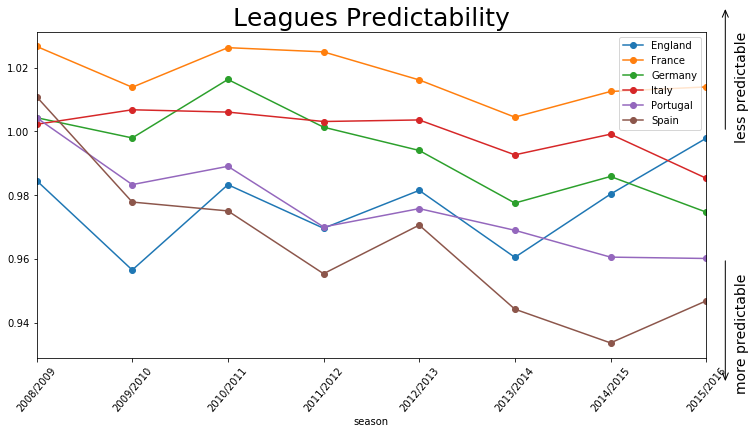

In [10]:
#plot graph
ax = entropy_means.plot(figsize=(12,6),marker='o')

#set title
plt.title('Leagues Predictability', fontsize=25)

#set ticks roatation
plt.xticks(rotation=50)

ax.annotate('less predictable', xy=(7.3, 1.028), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.3, 0.952), annotation_clip=False,fontsize=14,rotation='vertical')

#set arrow heads
ax.annotate('', xytext=(7.2, 1),xy=(7.2, 1.039),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)
ax.annotate('', xytext=(7.2, 0.96),xy=(7.2, 0.921),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

